In [74]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# UNCOMMENT IF IMAGE IS SAVED IN GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive/')

In [75]:
FIGSIZE = (25, 8) # display figure size
BLOCKSIZE = 16 # DCT window size

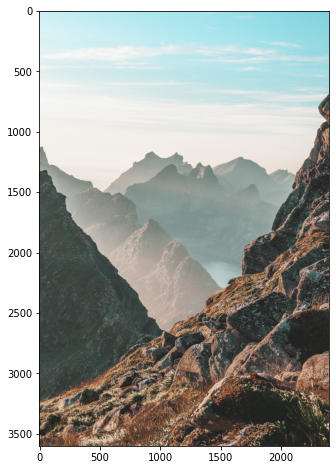

In [76]:
PATH = "data/large_image.jpg" # Large image to compare the effects of DCT one time
PATH2 = "data/stl.jpg" # Smaller image to compare the effects of DCT with different block sizes
img = Image.open(PATH)
img = np.asarray(img)

plt.figure(figsize=FIGSIZE)
plt.imshow(img)

# State of the Art: DCT

In [77]:
from scipy.fftpack import dct
from scipy.fftpack import idct

In [78]:
img.shape

(3600, 2400, 3)

In [79]:
'''
Performs Discrete Cosine Transform to a numpy matrix.

Params:
- mat: the numpy matrix representing an image to compress.
- blocksize: the dimension of the sliding window to apply DCT.
- d: the dimensionality of the transformation. 
     This is not useful now and so is set to always be 3 for images, but would be important for further work like in video compression.

Output:
The DCT matrix of mat. Note that this is not thresholded, and that is done with the method threshold_dct.
'''
def block_dct(mat, blocksize=BLOCKSIZE, d=3):
  dim = mat.shape
  transform = np.zeros(dim)

  for i in range(0, dim[0], BLOCKSIZE):
    for j in range(0, dim[1], BLOCKSIZE):
      tf = dct(dct(mat[i:i+BLOCKSIZE, j:j+BLOCKSIZE], axis=0, norm='ortho'), axis=1, norm='ortho')
      if d == 3:
        transform[i:i+BLOCKSIZE, j:j+BLOCKSIZE, :] = dct(tf, axis=2, norm='ortho')
      else:
        transform[i:i+BLOCKSIZE, j:j+BLOCKSIZE] = tf
  return transform

In [80]:
'''
Performs Inverse Discrete Cosine Transform to a numpy matrix.

Params:
- mat: the numpy matrix representing a compressed image.
- blocksize: the dimension of the sliding window to apply IDCT.
- d: the dimensionality of the transformation. 
     This is not useful now and so is set to always be 3 for images, but would be important for further work like in video compression.

Output:
The recovered image from performing idct.
'''
def block_idct(mat, blocksize=BLOCKSIZE, d=3):
  dim = mat.shape
  recovery = np.zeros(dim)

  for i in range(0, dim[0], BLOCKSIZE):
    for j in range(0, dim[1], BLOCKSIZE):
      r = idct(idct(mat[i:(i+BLOCKSIZE),j:(j+BLOCKSIZE)], axis=0, norm='ortho'), axis=1, norm='ortho')
      if d == 3:
        recovery[i:i+BLOCKSIZE, j:j+BLOCKSIZE, :] = idct(r, axis=2, norm='ortho')
      else:
        recovery[i:i+BLOCKSIZE, j:j+BLOCKSIZE] = r
  return recovery

In [81]:
'''
Thresholds the given numpy matrix to remove unnecessary data.

Params:
- tf: the matrix transformation obtained from block_dct().

Output:
The thresholded matrix from the DCT input.
'''
def threshold_dct(tf):
  thresh = 0.012
  dct_thresh = tf * (abs(tf) > (thresh*np.max(tf)))

  return dct_thresh

Keeping only 3.675451% of the DCT coefficients


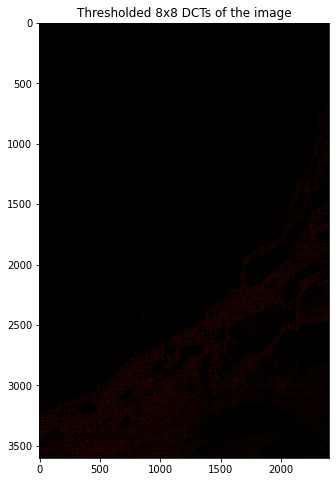

In [82]:
transform_full = block_dct(img) # Perform DCT
thresh_full = threshold_dct(transform_full) # Threshold the transform


plt.figure(figsize=FIGSIZE)
plt.imshow(thresh_full, cmap='gray',vmax=np.max(thresh_full)*0.01, vmin=0)
plt.title("Thresholded 8x8 DCTs of the image")

percent_nonzeros = np.sum(thresh_full != 0.0) / (img.shape[0]*img.shape[1]*1.0)

print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))

Text(0.5, 1.0, 'Comparison between original and DCT compressed images')

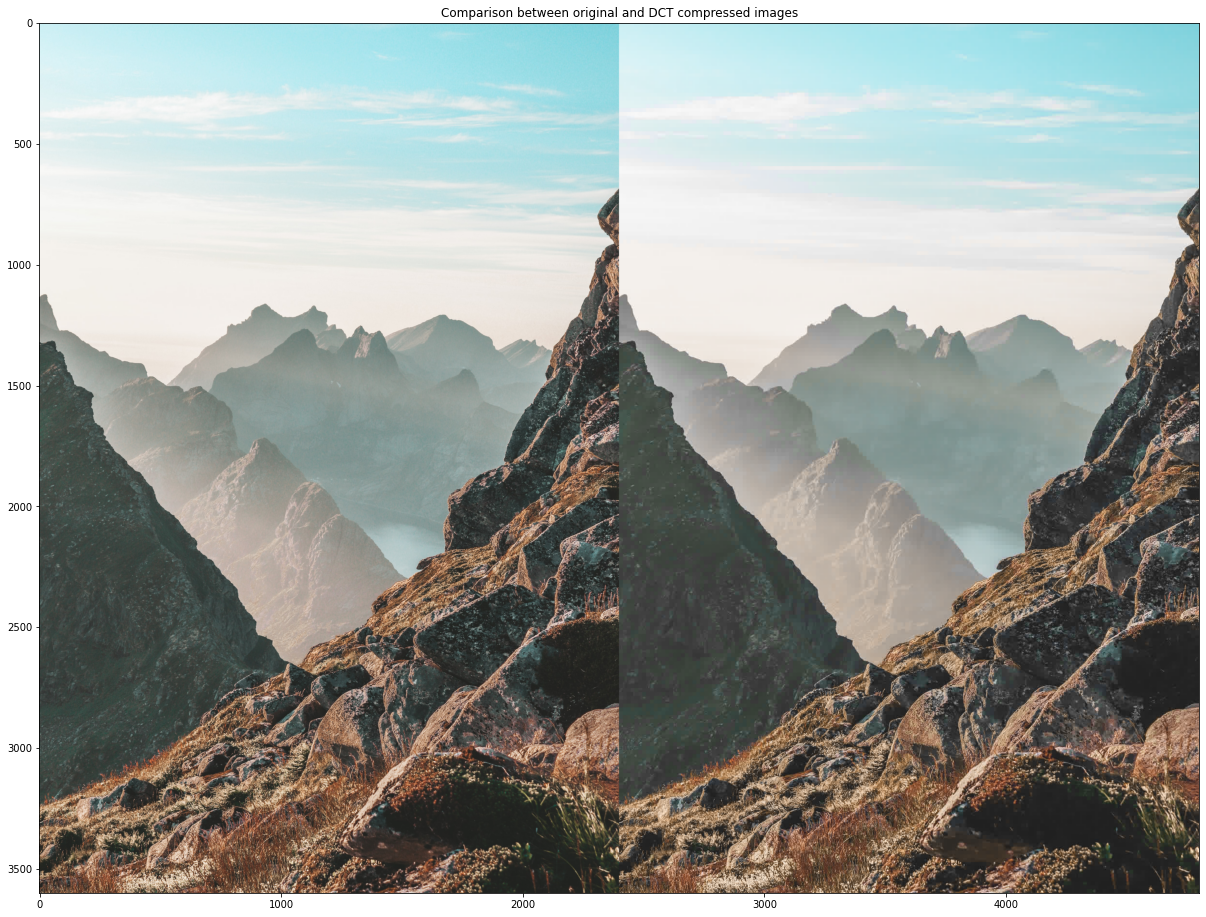

In [83]:
recovered_full = block_idct(thresh_full).astype(int)

plt.figure(figsize=(FIGSIZE[0], 2*FIGSIZE[1]))
plt.imshow(np.hstack( (img, recovered_full)))
plt.title("Comparison between original and DCT compressed images" )

# DCT on a smaller image using different block sizes to see if there's a difference

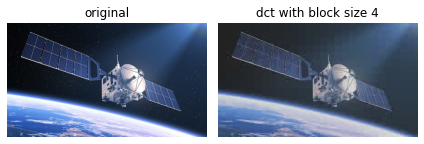

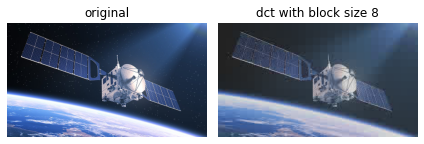

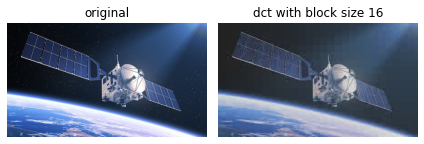

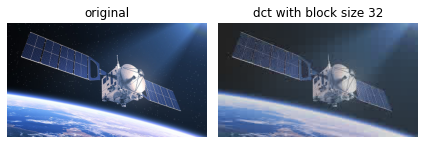

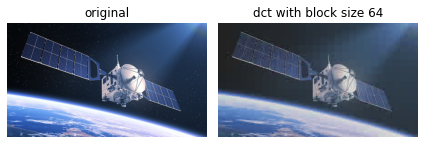

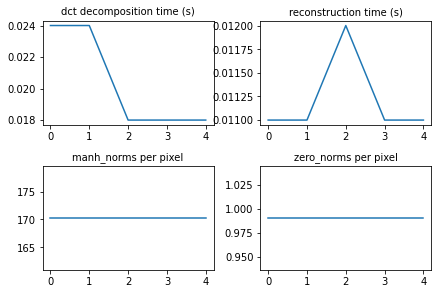

In [84]:
# !pip install tensorly

import os
import time
import numpy as np
import tensorly as tl
from PIL import Image
from math import ceil, exp
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorly.decomposition import tucker
from sklearn.preprocessing import normalize

# For pixel difference benchmark
from scipy.linalg import norm
from scipy import sum, average

import warnings
warnings.filterwarnings('ignore')

#**** End of import ****#

random_state = 12345
dct_time = []
recon_time = []
manh_norms = []
zero_norms = []

def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)


img = Image.open(PATH2)
img = tl.tensor(zoom(img,(0.5, 0.5, 1)), dtype='float64')
# img = tl.tensor(img, dtype='float64')

compression_amt = []

def tucker_experiment(img, b):
    start = time.time()
    # core, tucker_factors = tucker(img, rank=rank, init='random', tol=10e-5, random_state=random_state)
    img_thresh = threshold_dct(block_dct(img, b))
    end = time.time()
    percent_nonzeros = (np.sum(img_thresh != 0.0) / (img.shape[0]*img.shape[1]*1.0)) * 100.0
    compression_amt.append(percent_nonzeros)
#     dct_time = end-start
    dct_time.append(round(end-start, 3))
#     print(f"Tucker Decomposition took {round(dct_time, 3)} seconds")

    start = time.time()
    dct_reconstruction = block_idct(img_thresh, b)
    end = time.time()
#     recon_time = end-start
    recon_time.append(round(end-start, 3))
#     print(f"Reconstructing from tucker core took {round(recon_time, 3)} seconds")

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    ax.set_axis_off()
    ax.imshow(to_image(img))
    ax.set_title('original')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_axis_off()
    ax.imshow(to_image(dct_reconstruction))
    ax.set_title(f'dct with block size {b}')

    plt.tight_layout()
    plt.show()
  
    
    # compare pixel differences
    
    def compare_images(img1, img2):
        # normalize to compensate for exposure difference, this may be unnecessary
        # consider disabling it
        img1 = normalize(img1)
        img2 = normalize(img2)
        # calculate the difference and its norms
        diff = img1 - img2  # elementwise for scipy arrays
        m_norm = np.sum(abs(diff))  # Manhattan norm
        z_norm = norm(diff.ravel(), 0)  # Zero norm
        return (m_norm, z_norm)
    
    diff = to_image(img) - to_image(dct_reconstruction)
    m_norm = sum(abs(diff))  # Manhattan norm
    manh_norms.append(m_norm/to_image(img).size)
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    zero_norms.append(z_norm*1.0/to_image(img).size)
    # print(f"Manhattan norm: {m_norm}, per pixel: {m_norm/to_image(img).size}")
    # print(f"Zero norm: {z_norm}, per pixel: {z_norm*1.0/to_image(img).size}")
    
blocks = [4, 8, 16, 32, 64]
for b in blocks:
    tucker_experiment(img, b)

def plot_lines(ax, arr, title):
    ax.plot(arr)
    ax.set_title(title, fontsize=10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
plot_lines(ax1, dct_time, "dct decomposition time (s)")
plot_lines(ax2, recon_time, "reconstruction time (s)")
plot_lines(ax3, manh_norms, "manh_norms per pixel")
plot_lines(ax4, zero_norms, "zero_norms per pixel")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [85]:
compression_amt

[5.450569476082005,
 5.450569476082005,
 5.450569476082005,
 5.450569476082005,
 5.450569476082005]

# Tuckers Implementation

In [86]:
# Imports
# !pip install tensorly
import tensorly as tl
import numpy as np
from scipy.linalg import svd

In [87]:
N = 3 # Image dimensions
R = 5 # Core tensor rank
SHAPE = (300, 100, 3) # image shape
# img_tensor = tl.tensor(img)

In [88]:
# Test tensor. Used this since tucker had a lot of issue handling large images, so this let us test the boundaries of tucker quickly.
test = tl.tensor(np.random.randint(0, 255, size=SHAPE))
test.shape

(300, 100, 3)

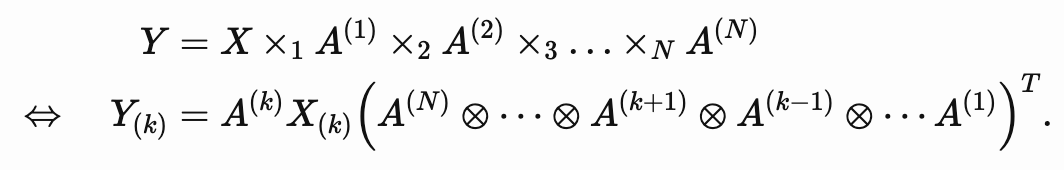

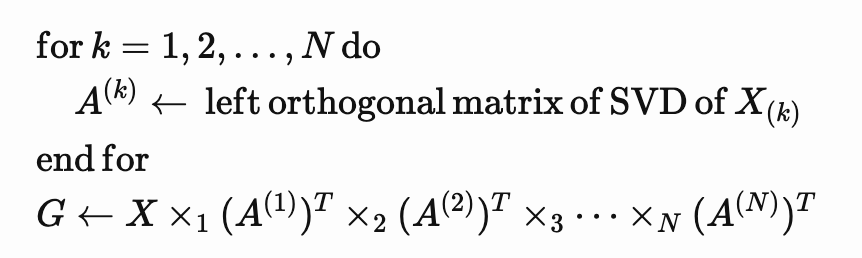

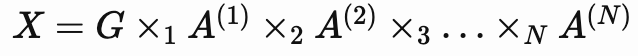

In [89]:
'''
Calculates the Kronecker product between two matrices.

Params:
- A: The first matrix in the product.
- B: The second matrix in the product.

Output:
The resulting matrix of the Kronecker product between A and B.
'''
def kron(A, B):
  C = tl.tensor(np.empty((A.shape[0]*B.shape[0], A.shape[1]*B.shape[1])))

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      C[i, j] = A[i // B.shape[0], j // B.shape[1]] * B[i % B.shape[0], j % B.shape[1]]
  return C

In [90]:
'''
Finds the Kronecker product of A^N x A^(N-1)...A^(1) as seen in the parenthesis of the equation for Y_(k) above.

Params:
- X: The matrix to decompose, representing an image.
- R: The rank we want the core tensor to be after decomposition.
- decomp: Defines whether we are using this function for decomposition or recomposition. Default is decomposition.

Output:
The Kronecker product of A^N x A^(N-1)...A^(1) as seen in the parenthesis of the equation for Y_(k) above.
'''
def kron_products(X, R, decomp=True):
  svds = []
  for k in range(1, N):
    U, s, VT = svd(tl.unfold(X, k))
    if decomp:
      svds.append(U.T[:R, :]) 
    else:
      svds.append(U)
  return kron(svds[0], svds[1]).T

In [91]:
'''
Performs Tucker decomposition using the Higher Order Singular Value Decomposition approach.

Params:
- X: The matrix to decompose, representing an image.
- R: The rank we want the core tensor to be after decomposition.

Output:
- G: The core tensor.
- List: A list of the factor matrices resulting from the decomposition.
        Since we are decomposing 3-dimensional images, there will always be 3 factor matrices.
'''
def tucker_svd(X, R):
  U, s, VT = svd(tl.unfold(X, 0))
  Ak = U[:R, :]
  y = kron_products(X, R)
  
  temp = tl.matmul(Ak, tl.unfold(X, 0))
  g = tl.matmul(temp, y)
  G = tl.fold(g, 0, (R, R, 3))

  A2 = svd(tl.unfold(X, 0))[0][:R, :]
  A1 = svd(tl.unfold(X, 1))[0][:R, :]
  A0 = svd(tl.unfold(X, 2))[0][:R, :]
  return G, [A0, A1, A2]

In [92]:
'''
Performs the Inverse Tucker decomposition.

Params:
- G: The core tensor.
- R: The rank (core tensor dimensions).
- factors: A list of the factor matrices relating to G.

Output:
The reconstruction of the inputs from some original image.
'''
def inv_tucker_svd(G, R, factors):
  products = kron(factors[1], factors[2])
  temp = tl.matmul(factors[0], tl.unfold(G, 2))
  X = tl.matmul(temp, products)
  return X.reshape(SHAPE)

In [93]:
# Perform tucker decomposition and display the core tensor dimensions
f, factors = tucker_svd(test, R)
f.shape

(5, 5, 3)

In [94]:
# The factors map from the core tensor dimensions to the original image dimensions
print(factors[0].shape)
print(factors[1].shape)
print(factors[2].shape)

(3, 3)
(5, 100)
(5, 300)


In [95]:
# Reconstruct the image and confirm that the dimensions are back to the original
r = inv_tucker_svd(f, R, factors)
r.shape

(300, 100, 3)

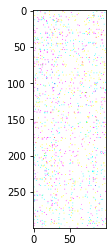

In [96]:
# Display the reconstructed image
plt.imshow(test-r)

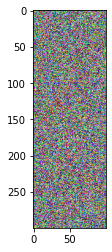

In [97]:
# Original image for reference
# Note that the test image is random. Experimentation on actual images in another notebook.
plt.imshow(test)